In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
import ipywidgets

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [60]:
def rho_red_light(x, rho_max):
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x<3.0)
    rho[mask] = 0.2 * rho_max
    return rho

In [61]:
#set parameters
nx = 81
L = 4.0
dx = L / (nx - 1)
nt = 40
rho_max = 10.0
u_max = 1.0

x = numpy.linspace(0.0, L, num = nx)

# compute!!
rho0 = rho_red_light(x, rho_max)

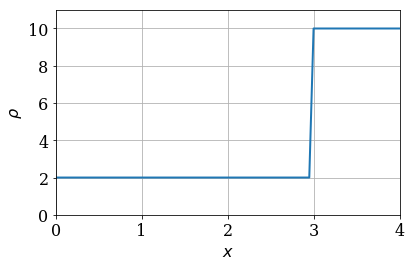

In [63]:
# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 11.0)
pyplot.tight_layout()

In [64]:
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [65]:
from matplotlib import animation
from IPython.display import HTML

In [66]:
def update_plot(n, rho_hist):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [67]:
# lax-friedrichs scheme

def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        #flux!
        F = flux(rho, *args)
        #advance in time
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) - 
                     dt / (2.0 *dx) * (F[2:] - F[:-2]))
        #set first value
        rho[0]  = bc_values[0]
        #set last  value
        rho[-1] = bc_values[1]
        #record time-step solution
        rho_hist.append(rho.copy())
    return rho_hist
        

In [68]:
# Set the time-step size based on CFL limit.
sigma = 1.0
dt = sigma * dx / u_max  # time-step size
nt = 40

# Compute the traffic density at all time steps.
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [69]:
def plot_density(n, rho_hist):
    pyplot.figure(figsize=(8.0,4.0))
    pyplot.xlabel('Distance [km]')
    pyplot.ylabel('Density [cars/km]')
    pyplot.grid()
    pyplot.plot(x, rho_hist[0], label='Initial')
    pyplot.plot(x, rho_hist[n], label='Time Step {}'.format(n))
    pyplot.ylim(rho_hist[0].min() - 1.0, rho_hist[0].max() +1.0)
    pyplot.legend()

In [70]:
nt_slider = ipywidgets.IntSlider(value = 0, min = 0, max = nt, 
                                setp = 1, description = 'time step')

display(ipywidgets.interactive(plot_density, n = nt_slider,
                               rho_hist = ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

The solution plotted above does travel to the left as expected however, the movement is not as smoth as it would be with the exact solution. As the wave travels it looks like a 64bit character in an old video game. This blockiness is one error observed in the solution. I think we can do better than the l-f scheme.

"Dig Deeper"

it seems a little more accurate than the other one

In [71]:
def jacobian(rho, u_max, rho_max):
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

In [72]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        #flux!
        F = flux(rho, *args)
        #jacobian :/
        J = jacobian(rho, *args)
        #advance...in time!
        rho[1:-1] = (rho[1:-1] - 
                     dt/ (2.0 * dx) * (F[2:] - F[:-2]) + 
                     dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) - 
                      (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [73]:
sigma = 1.0
dt = sigma*dx/u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [74]:
nt_slider = ipywidgets.IntSlider(value = 0, min = 0, max = nt, 
                                setp = 1, description = 'time step')

display(ipywidgets.interactive(plot_density, n = nt_slider,
                               rho_hist = ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [75]:
sigma = 0.5
dt = sigma*dx/u_max

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [76]:
nt_slider = ipywidgets.IntSlider(value = 0, min = 0, max = nt, 
                                setp = 1, description = 'time step')

display(ipywidgets.interactive(plot_density, n = nt_slider,
                               rho_hist = ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [77]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
        #flux!
        F = flux(rho, *args)
        #predictor
        rho_star[1:-1] = (rho[1:-1] - 
                          dt / dx * (F[2:] - F[1:-1]))
        #flux!
        F = flux(rho_star, *args)
        #corrector
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [78]:
sigma = 1.0
dt = sigma * dx / u_max

rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                       u_max, rho_max)

In [79]:
nt_slider = ipywidgets.IntSlider(value = 0, min = 0, max = nt, 
                                setp = 1, description = 'time step')

display(ipywidgets.interactive(plot_density, n = nt_slider,
                               rho_hist = ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [80]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [81]:
nt_slider = ipywidgets.IntSlider(value = 0, min = 0, max = nt, 
                                setp = 1, description = 'time step')

display(ipywidgets.interactive(plot_density, n = nt_slider,
                               rho_hist = ipywidgets.fixed(rho_hist)))

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [82]:
def maccormack_reverse(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):
       
        #flux!
        F = flux(rho_star, *args)
        #corrector
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))
        
         #flux!
        F = flux(rho, *args)
        #predictor
        rho_star[1:-1] = (rho[1:-1] - 
                          dt / dx * (F[2:] - F[1:-1]))
        
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [83]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx / u_max  # time-step size

# Compute the traffic density at all time steps.
rho_hist = maccormack_reverse(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [84]:
nt_slider = ipywidgets.IntSlider(value = 0, min = 0, max = nt, 
                                setp = 1, description = 'time step')

display(ipywidgets.interactive(plot_density, n = nt_slider,
                               rho_hist = ipywidgets.fixed(rho_hist)))


interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

Reversing the predictor and the corrector steps doesn't seem to have changed very much between the 0.5 sigma solutions, but the shape of the waves do vary slightly. Still, it hasn't changed enough from the original spikes to determine which is better resolved and a better choice.

changing the incoming rho to 2 (which is less than half the max density) causes the solutions to have a rigid traveling peak at the base of the wave as well as at the top of the shock wave. The wave also travels less distance as during the same number of time steps, so the velocity has decreased. This is most likely because negitive wave speeds mean slow down the shock wave velocity.